Install the `nomad` package from GitHub

In [18]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as npr
import random
from shapely.geometry import box
from pprint import pprint

import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street, RandomCityGenerator
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection as sd

from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import os
os.environ['TZ'] = 'UTC'

import pdb

Create City

In [19]:
city_generator = RandomCityGenerator(width=101, 
                                     height=101, 
                                     street_spacing=5, 
                                     park_ratio=0.05, 
                                     home_ratio=0.4, 
                                     work_ratio=0.3, 
                                     retail_ratio=0.25, 
                                     seed=100)
clustered_city = city_generator.generate_city()

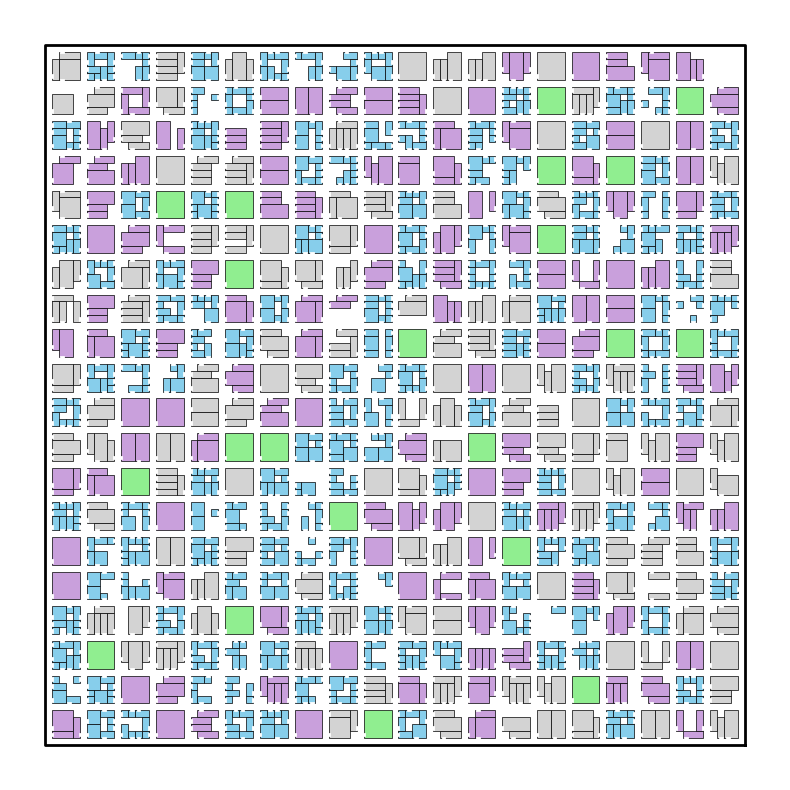

<Figure size 640x480 with 0 Axes>

In [20]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
plt.box(on=False)

clustered_city.plot_city(ax, doors=True, address=False)

# remove axis labels and ticks
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()
plt.savefig("random-city.png")

In [21]:
population = Population(clustered_city)
population.generate_agents(N=1, seed=100)

for i, agent_id in enumerate(population.roster):
    agent = population.roster[agent_id]
    agent.generate_trajectory(end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0),
                              seed=100+i)
    agent.sample_trajectory(
        beta_start=300,
        beta_durations=60,
        beta_ping=10,
        seed=100+i)
    sampled_traj = agent.sparse_traj

/Users/andresmondragon/nomad/nomad/traj_gen.py:569: UserWarning: The end_time input is timezone-naive. Assuming it is in UTC.
  warnings.warn(


In [22]:
Zach = population.roster['nifty_saha']

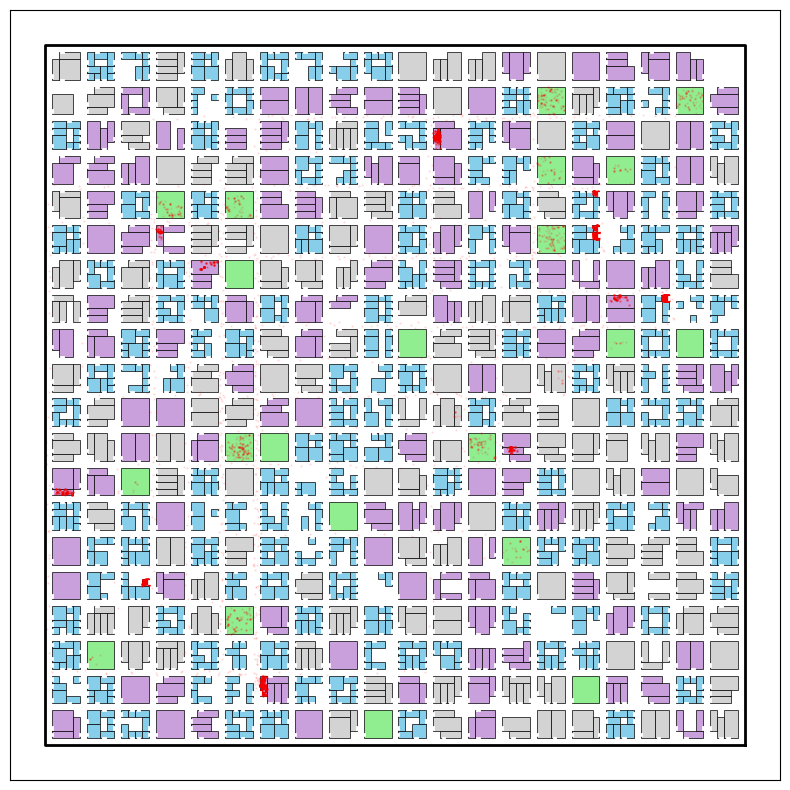

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
clustered_city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(x=Zach.trajectory.x, 
           y=Zach.trajectory.y, 
           s=0.5, color='red', alpha=0.1)

plt.savefig("random-city-one-user.png")